In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.datasets import make_blobs

from sklearn import svm

## Главная идея

Задача: найти наиболе "правильную" линию или гиперплоскость разделяющие данные на два разных класса.


Максимилизация интервала
![ris01](pict/vector.png)

Ядерный трюк
![ris02](pict/kernel.png)

## Математика SVM на примере бинарной классификации

$y = \{-1, +1\}$ - метки классов.\
$x = (x_1,x_2,...,x_n)$ признаки в пространстве $\mathbb{R}^n$\
$$f(x)\to y$$

Главная цель найти уравнение гиперплоскости:
$ w_1 x_1 + ... + w_n x_n + w_0 = 0 $ в пространстве  $\mathbb{R}^n$. ё

В общем виде:
$$ \text{sign}(w^T-b)\to \{-1, +1\}  $$
где $w=(w_1,...,w_n)$, $b=w_0$

Важный коментарий! Так как внутри $\text{sign}$ стоит линейная комбинация весов, наш алгоритм относится к классу линейных алгоритмов (однако несмотря на "линейность" есть так называемый "ядерный трюк", но об этом чуть позднее).

Разделяющею гиперплоскость можно строить различными спосабами, но в SMV веса $w$ и $b$ подбираются так, чтобы объекты лежали как можно дальше друг от друга.

<img src="pict/svm.png" width="400"/>

$w=(w_1,w_2)$ - искомый векор весов

$A x_1+B x_2+ c=0$ - уравнение прямой

$$w_1 x_1 + w_2 x_2 - b + 1 = 0$$
$$w_1 x_1 + w_2 x_2 - b - 1 = 0$$

$$\rho(//) = \frac{C_1+C_2}{\sqrt{A^2+B^2}} = \frac{-b+1+b+1}{\sqrt{w_1^2+w_2^2}}=
\frac{2}{||w||}$$

Тогда:
$$\frac{2}{||w||}\to \max \Rightarrow ||w||\to \min \Rightarrow 
\frac{1}{2}||w||=\frac{(w^Tw)}{2}\to \min$$

Отступом (margin) - наз величину:
$$ M = y(w^T x -b) $$
- если $M>0$, то $y$ и $(w^T x -b)$  имеют различные знаки;
- если $M\in(0,1)$, то объект внутри разделительной полосы;
- если $M>0$, то $y(w^T x -b)\geq 1$  и объект правильно классифицирован.

### SVM с жестким зазором

Таким образом для наших объектов, которым запрещено попадать в полосу разделения (работает только линейно разделимых объектов) можно записать

$$
\begin{cases}
  (w^T w)/2 \to \min \\ 
  y(w^T x -b)\geq 1  
\end{cases}
$$

Данная задача имеет аналитическое решение. (По теореме Куна-Таккера эта задача эквивалентна двойственной задаче поиска седловой точки функции Лагранжа ... дальше умными словами пугать не буду, но там есть про прозводные по вектору $w$, которые должны быть равны 0, что открывает нам путь численного решения через градиентный спуск.

### SVM с мягким зазором
Если объектам разрешить попадать в полосу разделения (работает с не только линейно разделимых объектов), то для решения этой задачи введем доколнительный набор переменных $\xi_i \geq 0$ и введём в минимизизацию штраф за суммарную ошибку.
$$
\begin{cases}
  (w^T w)/2 + \alpha\sum_i \xi_i \to \min \\ 
  y(w^T x -b)\geq 1-\xi_i \\
  \xi_i \geq 0
\end{cases}
$$

И тут уже с аналитическим решением туго, но помним про градиентный спуск.

### Посчитаем ошибки

Будем считать количество ошибок алгоритма, когда $M<0$). Назовем это штрафом (Penalty). Тогда штраф для всех объектов будет равен сумме штрафов для каждого объекта $x_i$, где $M_i<0$.

$$Penalty = \sum[M_i < 0]$$


$$ [M_i < 0] =
\begin{cases} 
    1 & \textrm{, если }M_i < 0\\ 
    0 & \textrm{, если }M_i\geq 0 
\end{cases}
$$

Теперь сделаем штраф зависимым от величине ошибки (чем сильнее $M$ "уходит в минус" — тем больше штраф) и заодно оштрафуем за приближение объекта к границе разделяющей классы. Для этого возьмем функцию, которая ограничивает пороговую функцию ошибки:

$$Penalty = \sum[M_i < 0] \leq \sum [1- M_i]_+ = \sum max(0,[1-M_i])$$

и получим функцию потрерь для одного оюъекта (в варианте с мягим зазором):

$$Q =max(0,1- M_i) + \alpha(w^Tw)/2$$

$$Q =max(0,1- yw^Tx) + \alpha(w^Tw)/2$$

$Q$ — функция потерь, она же loss function. Именно ее мы и сможем минимизировать с помощью градиентного спуска. 

### Проблемы метода и ядерный трюк

Метод классификации разделяющей полосой имеет два недостатка:
- в поиске разделяющей полосы существенное значение имеют только пограничные точки;
- во многих случаях найти оптимальную разделяющую полосу невозможно.

**Идея ядерного трюка**

Построение машины опорных векторов:
1. Выберем отображение $\phi(x)$ векторов $x$ в новое, расширенное пространство.
2. Автоматически получается новая функция скалярного произведения $K(u, v) = \phi(u) \phi(v)$. На практике обычно выбирают не отображение $\phi(x)$, а сразу функцию $K(u, v)$, которая могла бы быть скалярным произведением при некотором отображении $\phi(x)$. Функция $K(u, v)$ называется ядром. Эта функция есть главный параметр настройки машины опорных векторов.
3. Находим разделяющую гиперплоскость в новом пространстве: с помощью функции $K(u, v)$ мы составляем новую матрицу коэффициентов для задачи оптимизации, подставляя вместо $(x_i, x_j)$ значение $K(x_i,x_j)$, и решаем новую задачу оптимизации.
4. Найдя $w$ и $b$, получаем классифицирующую поверхность $w·\phi(x)−b$ в новом, расширенном пространстве.

Приведем простой пример. Есть точки на плоскости. Перенесем точки с плоскости на сферу. Решение готово, срезали часть сферу плоскостью!

<img src="pict/sphere.png" width="400"/>

Выгнули пространство с помощью $\phi(x)$ решили проблему.

Теперь чуть сложнее:

$$\phi(x) = \phi((x_1, x_2)) \to (x^2_1, x^2_2, \sqrt{2}x_1 x_2)$$

$$K(u, v) = u^2_1 v^2_1 + u^2_2 v^2_2 + 2 u_1u_2v_1v_1 = (u,v)^2$$

Очевидно, что не обязательно считать $phi(u)$ и $phi(v)$, чтобы сосчитать скалярное произведение. Можно сразу сказать, что новое скалярное произведение есть старое скалярное произведение в квадрате. Это очень полезно, так как в данном примере пространство увеличилось всего на одну координату, а в практических ядрах оно может увеличиться во много раз, и в таких случаях считать скалярное произведение через функцию $\phi$ может быть очень невыгодно.


Итак давайте перечисли наиболее популярные ядра реализованные `scikit-learn`:
- `linear` - $K(u,v) = u^T v$
- `poly` - $K(u,v) = (\gamma u^T v +r)^d$, где $d$ степень полинома, $\gamma$ - контролирует влияние каждой отдельной обучающей строки на границу принятия решения, $r$ - контролирует сдвиг разделяющей плоскости (выше/ниже)
- `rbf` - гаусовское ядро - $K(u,v) = \exp(-\gamma ||u-v||^2)$ - $\gamma$ - контролирует влияние каждой отдельной обучающей строки на границу принятия решения. Чем больше евклидово расстояние между двумя точками данных, тем ближе функция ядра к нулю. Это означает, что с ростом растояния между точками данных, растет непохожесть.
- `sigmoid` - $K(u,v) = \text{tanh}\;(\gamma u^T v +r)$. В сигмовидном ядре сходство между двумя точками данных вычисляется с использованием гиперболической функции. 
- `precomputed` - собственное, предварительно вычисленное ядро.

Идея метода предложена советским ученым В.Н. Вапником в 60-х годах. В 90-х эмигрировал в США и работая компании Bell, поспорил с коллегами, фактически "на кружку пива",  что его алгоритм распознает рукописные цифры лучше их алгоритмом. [Его решение смогли превзойти только нейросети, но на гораздо больших объемах обучающей выборки.](https://en.wikipedia.org/wiki/MNIST_database)

## Разные ядра - разное деление

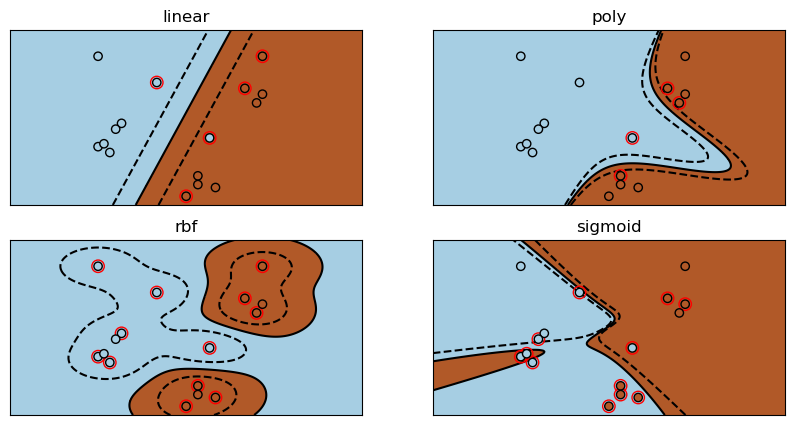

In [74]:
X = np.c_[(.4, -.7),
          (-1.5, -1),
          (-1.4, -.9),
          (-1.3, -1.2),
          (-1.1, -.2),
          (-1.2, -.4),
          (-.5, 1.2),
          (-1.5, 2.1),
          (1, 1),
          # --
          (1.3, .8),
          (1.2, .5),
          (.2, -2),
          (.5, -2.4),
          (.2, -2.3),
          (0, -2.7),
          (1.3, 2.1)].T
Y = [0] * 8 + [1] * 8


_, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True);
ax = np.ravel(ax)

kernel = ['linear', 'poly', 'rbf','sigmoid']

for i in range(len(kernel)):
    clf = svm.SVC(kernel=kernel[i], gamma = 2)# 0.1, 1, 2 - чем больше тем меньше опорных векторов
    clf.fit(X, Y)

    ax[i].scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, edgecolors='r')
    ax[i].scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,
                edgecolors='k')

    ax[i].axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)

    ax[i].pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired, shading='auto')
    ax[i].contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    ax[i].set_xlim(x_min, x_max)     
    ax[i].set_ylim(y_min, y_max)
    ax[i].set_title(kernel[i])

    ax[i].set_xticks(())
    ax[i].set_yticks(())

plt.show()

## Линейный SVM

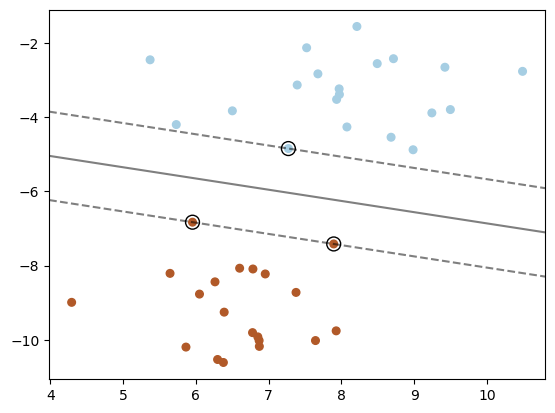

In [13]:
X, y = make_blobs(n_samples=40, centers=2, random_state=6)# 42


clf = svm.SVC(kernel='linear')
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()


xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)


ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

## Ядерный SVM

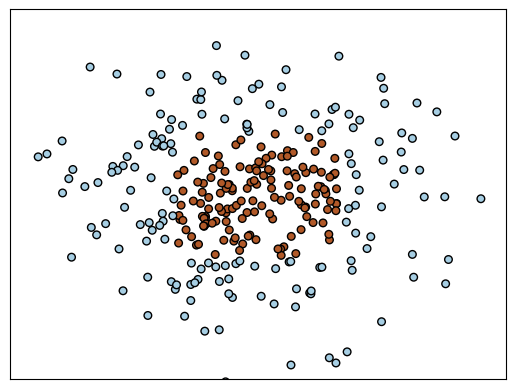

In [14]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
y = np.logical_and(np.logical_and(X[:, 0]>-1, X[:, 0]<1), np.logical_and(X[:, 1] > -1,X[:, 1] < 1))


plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

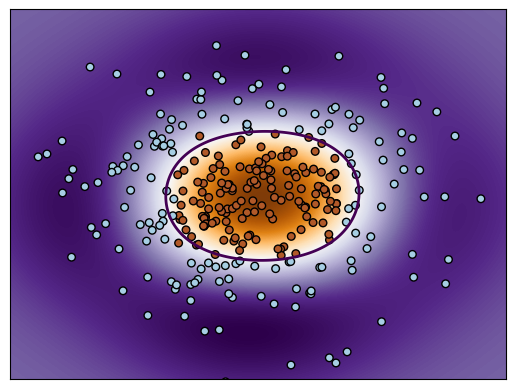

In [15]:
clf = svm.SVC(gamma='auto')
clf.fit(X, y)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='spline16',
            extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
            origin='lower', cmap=plt.cm.PuOr_r)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

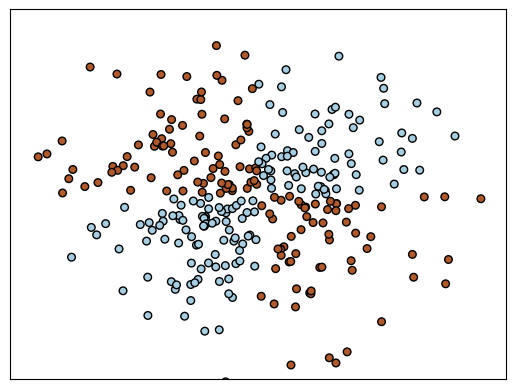

In [16]:
xx, yy = np.meshgrid(np.linspace(-4, 4, 500),
                     np.linspace(-3, 3, 500))
np.random.seed(0)
X = np.random.randn(300, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)


plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

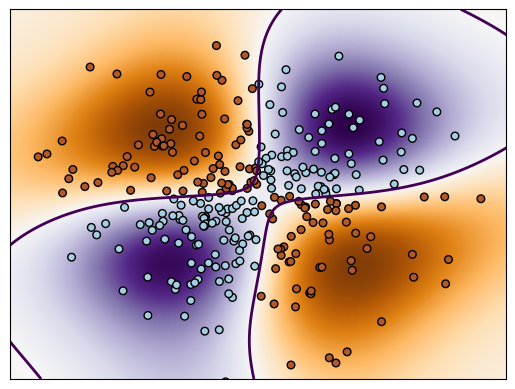

In [17]:
clf = svm.SVC(gamma='auto')
clf.fit(X, y)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='spline16',
            extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
            origin='lower', cmap=plt.cm.PuOr_r)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

## Настройка параметров SVM

1. Параметр <code>С</code> - помогает отрегулировать  грань между "гладкостью" и точностью классификации объектов обучающей выборки. Чем больше значение <code>С</code>, тем больше объектов обучающей выборки будут правильно классифицированы и тем менее "прямая" линяя будет делить классы.

2. Параментр <code>gamma</code> определяет насколько далеко каждый из элементов в наборе данных имеет влияние при определении "идеальной линии". </br>
Чем ниже гамма, тем больше элементов, даже тех, которые достаточно далеки от разделяющей линии, принимают участие в процессе выбора этой самой линии. </br>
Если же, гамма высокая, тогда алгоритм будет “опираться” только на тех элементах, которые наиболее близки к самой линии.</br>
Если задать уровень гаммы слишком высоким, тогда в процессе принятия решения о расположении линии будут учавствовать только самые близкие к линии элементы. Это поможет игнорировать выбросы в данных. 

При правильной настройке <code>С</code> и <code>gamma</code> можно добиться оптимального результата, который построит более линейную гиперплоскость игнорирующую выбросы, и следовательно, более генерализуемую.

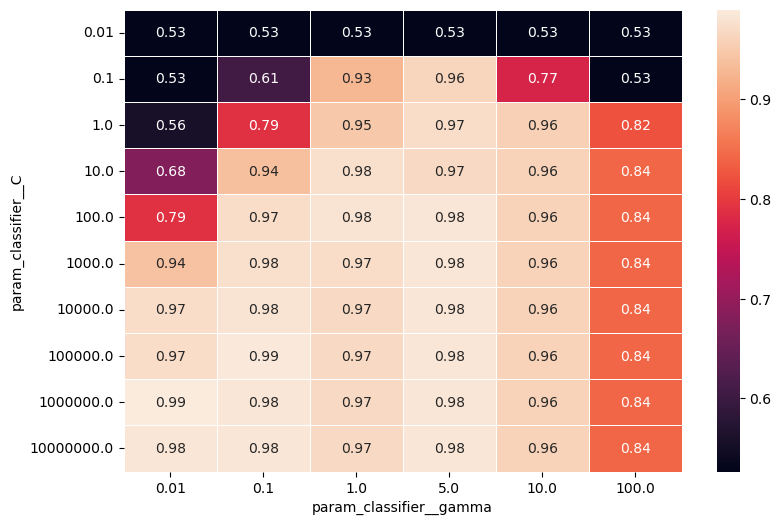

In [18]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', svm.SVC())])

C=np.array([0.01,0.1,1,10,100,10**3,10**4, 10**5,10**6,10**7])
gamma=[0.01,0.1,1,5,10,100]

param_grid =[
    {'preprocessing': [StandardScaler()], 
     'classifier': [svm.SVC()],
     'classifier__C': C,
     'classifier__gamma': gamma
     }
]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)
grid.fit(X,y)
table=pd.DataFrame(grid.cv_results_)
pv_table=table.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='mean_test_score')
pv_table
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pv_table, annot=True, linewidths=.5, ax=ax);

<Axes: xlabel='param_classifier__gamma', ylabel='param_classifier__C'>

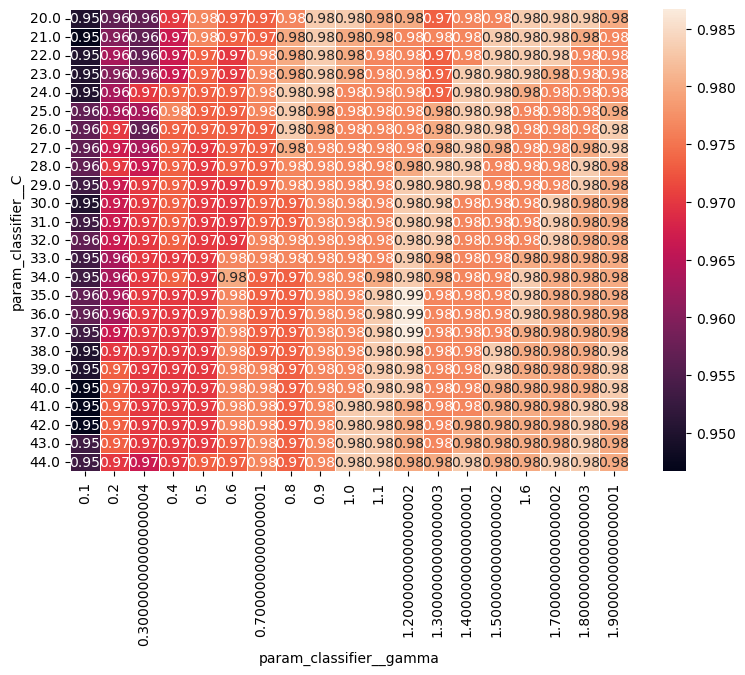

In [19]:
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('classifier', svm.SVC())])

C=np.arange(20., 45.)
gamma=np.arange(0.1,2.0, 0.1)


param_grid =[
    {'preprocessing': [StandardScaler()], 
     'classifier': [svm.SVC()],
     'classifier__C': C,
     'classifier__gamma': gamma
     }
]

grid = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True)
grid.fit(X,y)
table=pd.DataFrame(grid.cv_results_)
pv_table=table.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='mean_test_score')
pv_table
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(pv_table, annot=True, linewidths=.5, ax=ax);

In [20]:
pv_table.stack().head(10)

param_classifier__C  param_classifier__gamma
20.0                 0.1                        0.950000
                     0.2                        0.956667
                     0.3                        0.956667
                     0.4                        0.970000
                     0.5                        0.976667
                     0.6                        0.973333
                     0.7                        0.973333
                     0.8                        0.976667
                     0.9                        0.983333
                     1.0                        0.983333
dtype: float64

In [21]:
display(pv_table.stack().max())
display(pv_table.stack().idxmax())

0.9866666666666667

(35.0, 1.2000000000000002)

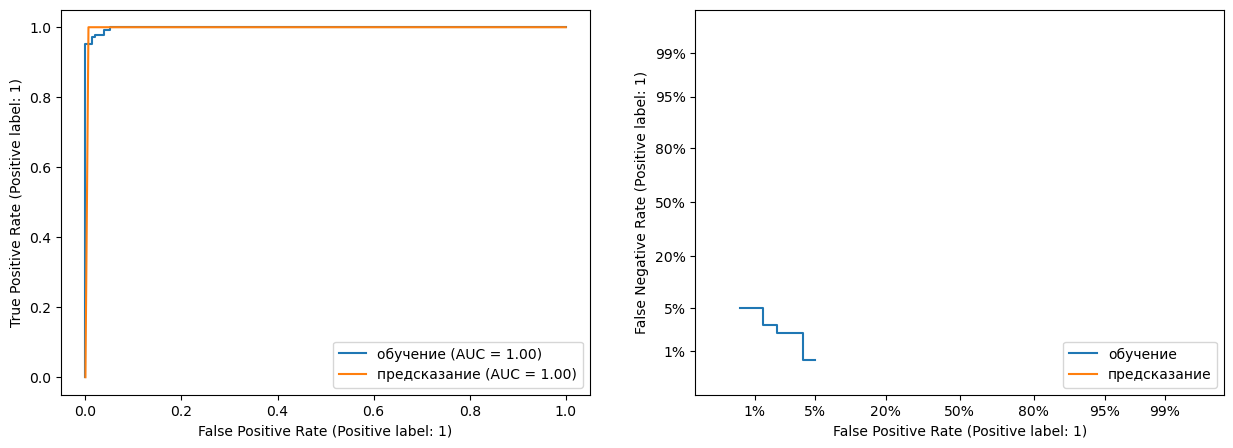

In [23]:
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay

cls = make_pipeline( StandardScaler(),svm.SVC(C=35, gamma=1.2) )
cls.fit(X,y)
y_pred = cls.predict(X)

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(15, 5))
RocCurveDisplay.from_estimator(clf, X, y, ax=ax_roc, name='обучение');
RocCurveDisplay.from_predictions(y, y_pred, ax=ax_roc, name='предсказание');

DetCurveDisplay.from_estimator(clf, X, y, ax=ax_det, name='обучение');
DetCurveDisplay.from_predictions(y, y_pred, ax=ax_det, name='предсказание');

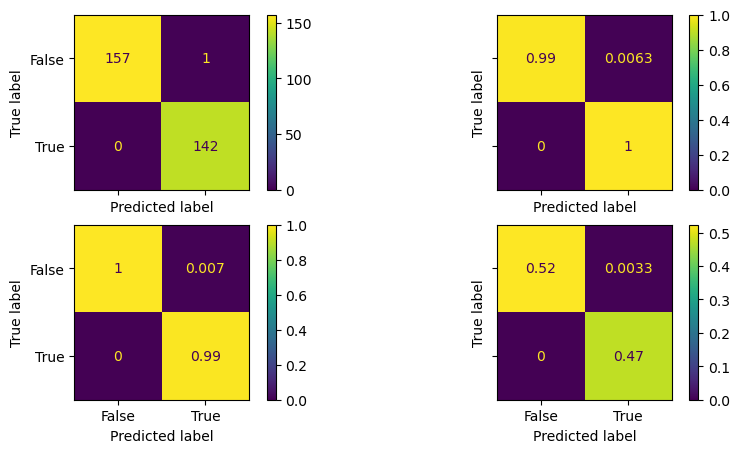

In [77]:
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y,y_pred)

_, ax = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True);

ConfusionMatrixDisplay.from_predictions(y, y_pred, ax=ax[0,0]);
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='true', ax=ax[0,1]);
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='pred', ax=ax[1,0]);
ConfusionMatrixDisplay.from_predictions(y, y_pred, normalize='all', ax=ax[1,1]);